In [27]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [86]:
tasks_fn = 'resources/house_target_tuple.json'
games_fn = '../tasks/dialog_navigation/all.json'
instruction_following_fn = '../tasks/instruction_following/all.json'

with open(tasks_fn, 'r') as f:
    house_target_tuple = json.load(f)

In [87]:
# Enumerate distances inside of task tuple data.
task_ds = []
for house in house_target_tuple:
    for _, _, _, _, end_pano_ds in house_target_tuple[house]:
        task_ds.append(min(end_pano_ds))

In [88]:
# Enumrate distances inside of matterport R2R data.
mp_ds = []
for fn in ['../../../tasks/R2R/data/R2R_train.json',
           '../../../tasks/R2R/data/R2R_val_seen.json',
           '../../../tasks/R2R/data/R2R_val_unseen.json']:
    with open(fn, 'r') as f:
        mp_data = json.load(f)
    for trajectory in mp_data:
        mp_ds.append(len(trajectory['path']))

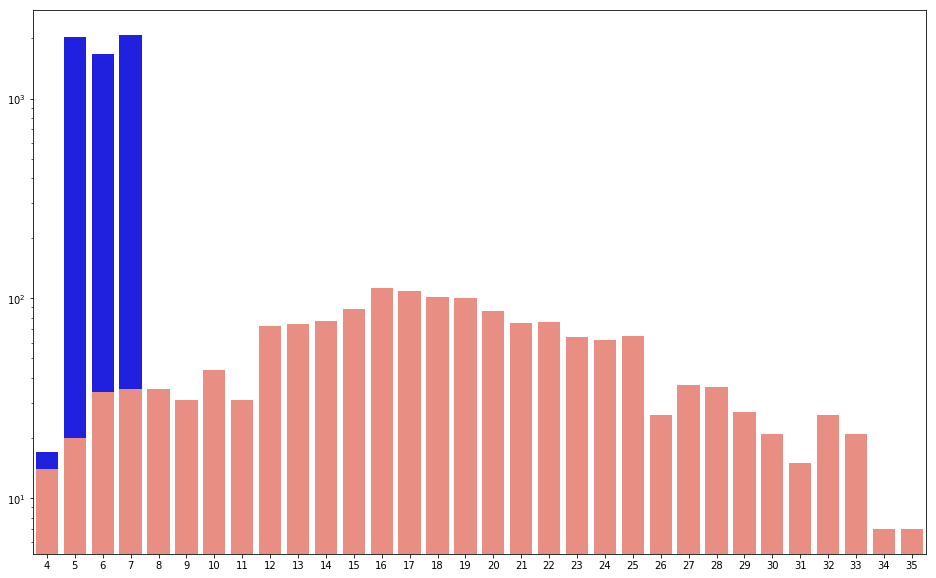

MPD average hops:	18.21+/-6.68, (n=1629)
MP R2R average hops:	6.00+/-0.85, (n=5798)


In [89]:
# Visualize tuple path distances.
bin_size = 1

freq_of_task_ds_count_bins = {}
for c in task_ds:
    cbin = c // bin_size
    if cbin not in freq_of_task_ds_count_bins:
        freq_of_task_ds_count_bins[cbin] = 0
    freq_of_task_ds_count_bins[cbin] += 1

freq_of_mp_ds_count_bins = {}
for c in mp_ds:
    cbin = c // bin_size
    if cbin not in freq_of_mp_ds_count_bins:
        freq_of_mp_ds_count_bins[cbin] = 0
    freq_of_mp_ds_count_bins[cbin] += 1

for cbin in range(min(min(freq_of_mp_ds_count_bins), min(freq_of_task_ds_count_bins)),
                  max(max(freq_of_mp_ds_count_bins), max(freq_of_task_ds_count_bins)) + 1):
    if cbin not in freq_of_mp_ds_count_bins:
        freq_of_mp_ds_count_bins[cbin] = 0
    if cbin not in freq_of_task_ds_count_bins:
        freq_of_task_ds_count_bins[cbin] = 0

fig, ax = plt.subplots(figsize=(16, 10))
g1 = sns.barplot(ax=ax,
                 x=[k * bin_size for k in freq_of_mp_ds_count_bins],
                 y=[freq_of_mp_ds_count_bins[k] for k in freq_of_mp_ds_count_bins],
                 color="blue")
g2 = sns.barplot(ax=ax,
                 x=[k * bin_size for k in freq_of_task_ds_count_bins],
                 y=[freq_of_task_ds_count_bins[k] for k in freq_of_task_ds_count_bins],
                 color="salmon")
ax.set(yscale="log")
plt.show()

print("MPD average hops:\t%.2f+/-%.2f, (n=%d)" % (np.mean(task_ds), np.std(task_ds), len(task_ds)))
print("MP R2R average hops:\t%.2f+/-%.2f, (n=%d)" % (np.mean(mp_ds), np.std(mp_ds), len(mp_ds)))

In [90]:
# Load games data.
with open(games_fn, 'r') as f:
    games = pd.read_json(json.load(f))

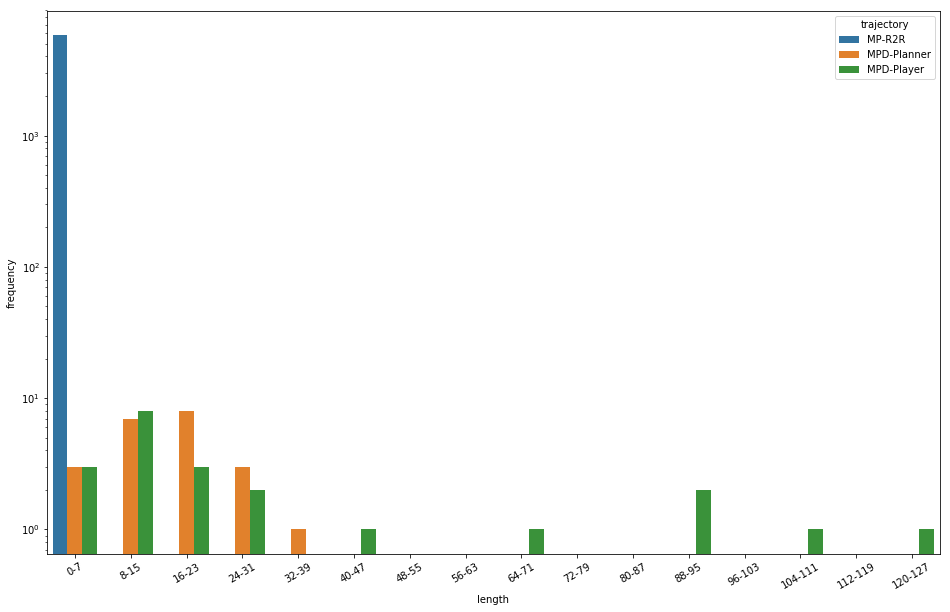

MP R2R average hops:	6.00+/-0.85, (n=5798)
MPD Player average hops:	33.59+/-36.63, (n=22)
MPD Planner average hops:	17.05+/-7.01, (n=22)


In [91]:
# Examine distribution of dialog navigation lengths versus MatterPort.
bin_size = 8

ins_ds = [len(games['planner_nav_steps'][idx]) for idx in games.index]
freq_of_ins_ds_count_bins = {}
for c in ins_ds:
    cbin = c // bin_size
    if cbin not in freq_of_ins_ds_count_bins:
        freq_of_ins_ds_count_bins[cbin] = 0
    freq_of_ins_ds_count_bins[cbin] += 1
    
player_ds = [len(ins_follow['nav_steps'][idx]) for idx in games.index]
freq_of_player_ds_count_bins = {}
for c in player_ds:
    cbin = c // bin_size
    if cbin not in freq_of_player_ds_count_bins:
        freq_of_player_ds_count_bins[cbin] = 0
    freq_of_player_ds_count_bins[cbin] += 1

freq_of_mp_ds_count_bins = {}
for c in mp_ds:
    cbin = c // bin_size
    if cbin not in freq_of_mp_ds_count_bins:
        freq_of_mp_ds_count_bins[cbin] = 0
    freq_of_mp_ds_count_bins[cbin] += 1

for cbin in range(min(min(freq_of_mp_ds_count_bins), min(freq_of_ins_ds_count_bins), min(freq_of_player_ds_count_bins)),
                  max(max(freq_of_mp_ds_count_bins), max(freq_of_ins_ds_count_bins), max(freq_of_player_ds_count_bins)) + 1):
    if cbin not in freq_of_mp_ds_count_bins:
        freq_of_mp_ds_count_bins[cbin] = 0
    if cbin not in freq_of_ins_ds_count_bins:
        freq_of_ins_ds_count_bins[cbin] = 0

d = [{'length': "%d-%d" % (k * bin_size, (k+1) * bin_size - 1) if bin_size > 1 else k * bin_size,
      'trajectory': 'MP-R2R',
      'frequency': freq_of_mp_ds_count_bins[k]} for k in freq_of_mp_ds_count_bins]
d.extend([{'length': "%d-%d" % (k * bin_size, (k+1) * bin_size - 1) if bin_size > 1 else k * bin_size,
           'trajectory': 'MPD-Planner',
           'frequency': freq_of_ins_ds_count_bins[k]} for k in freq_of_ins_ds_count_bins])
d.extend([{'length': "%d-%d" % (k * bin_size, (k+1) * bin_size - 1) if bin_size > 1 else k * bin_size,
           'trajectory': 'MPD-Player',
           'frequency': freq_of_player_ds_count_bins[k]} for k in freq_of_player_ds_count_bins])
fig, ax = plt.subplots(figsize=(16, 10))
df = pd.DataFrame(d)
g = sns.barplot(ax=ax, x='length', y='frequency', hue="trajectory", data=df)
ax.set(yscale="log")
if bin_size > 1:
    g.set_xticklabels(g.get_xticklabels(), rotation=30)
plt.show()

print("MP R2R average hops:\t%.2f+/-%.2f, (n=%d)" % (np.mean(mp_ds), np.std(mp_ds), len(mp_ds)))
print("MPD Player average hops:\t%.2f+/-%.2f, (n=%d)" % (np.mean(player_ds), np.std(player_ds), len(player_ds)))
print("MPD Planner average hops:\t%.2f+/-%.2f, (n=%d)" % (np.mean(ins_ds), np.std(ins_ds), len(ins_ds)))

In [93]:
# Load instruction following data.
with open(instruction_following_fn, 'r') as f:
    ins_follow = json.load(f)

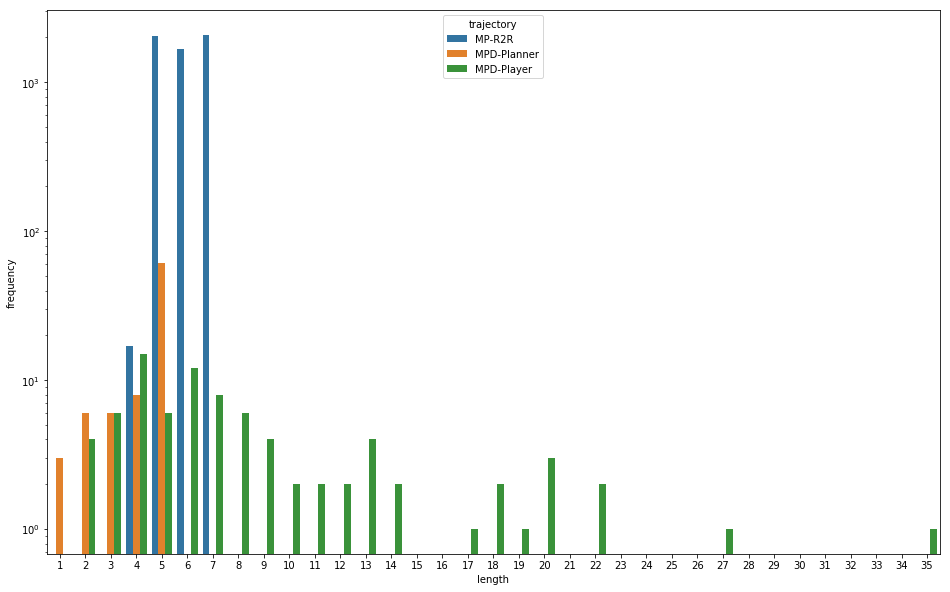

MP R2R average hops:	6.00+/-0.85, (n=5798)
MPD IF Player average hops:	8.48+/-6.15, (n=84)
MPD IF Planner average hops:	4.40+/-1.11, (n=84)


In [95]:
# Examine distribution of instruction following lengths versus MatterPort.
bin_size = 1

ins_ds = [len(task['planner_path']) for task in ins_follow]
freq_of_ins_ds_count_bins = {}
for c in ins_ds:
    cbin = c // bin_size
    if cbin not in freq_of_ins_ds_count_bins:
        freq_of_ins_ds_count_bins[cbin] = 0
    freq_of_ins_ds_count_bins[cbin] += 1
    
player_ds = [len(task['player_path']) for task in ins_follow]
freq_of_player_ds_count_bins = {}
for c in player_ds:
    cbin = c // bin_size
    if cbin not in freq_of_player_ds_count_bins:
        freq_of_player_ds_count_bins[cbin] = 0
    freq_of_player_ds_count_bins[cbin] += 1

freq_of_mp_ds_count_bins = {}
for c in mp_ds:
    cbin = c // bin_size
    if cbin not in freq_of_mp_ds_count_bins:
        freq_of_mp_ds_count_bins[cbin] = 0
    freq_of_mp_ds_count_bins[cbin] += 1

for cbin in range(min(min(freq_of_mp_ds_count_bins), min(freq_of_ins_ds_count_bins), min(freq_of_player_ds_count_bins)),
                  max(max(freq_of_mp_ds_count_bins), max(freq_of_ins_ds_count_bins), max(freq_of_player_ds_count_bins)) + 1):
    if cbin not in freq_of_mp_ds_count_bins:
        freq_of_mp_ds_count_bins[cbin] = 0
    if cbin not in freq_of_ins_ds_count_bins:
        freq_of_ins_ds_count_bins[cbin] = 0

d = [{'length': k * bin_size,
      'trajectory': 'MP-R2R',
      'frequency': freq_of_mp_ds_count_bins[k]} for k in freq_of_mp_ds_count_bins]
d.extend([{'length': k * bin_size,
           'trajectory': 'MPD-Planner',
           'frequency': freq_of_ins_ds_count_bins[k]} for k in freq_of_ins_ds_count_bins])
d.extend([{'length': k * bin_size,
           'trajectory': 'MPD-Player',
           'frequency': freq_of_player_ds_count_bins[k]} for k in freq_of_player_ds_count_bins])
fig, ax = plt.subplots(figsize=(16, 10))
df = pd.DataFrame(d)
g = sns.barplot(ax=ax, x='length', y='frequency', hue="trajectory", data=df)
ax.set(yscale="log")
plt.show()

print("MP R2R average hops:\t%.2f+/-%.2f, (n=%d)" % (np.mean(mp_ds), np.std(mp_ds), len(mp_ds)))
print("MPD IF Player average hops:\t%.2f+/-%.2f, (n=%d)" % (np.mean(player_ds), np.std(player_ds), len(player_ds)))
print("MPD IF Planner average hops:\t%.2f+/-%.2f, (n=%d)" % (np.mean(ins_ds), np.std(ins_ds), len(ins_ds)))

In [ ]:
# TODO: human performance on the instruction following task based on official R2R metrics.